# Fine-tuning YOLOv8 en DocBank Dataset

Este notebook guiará el proceso de fine-tuning de YOLOv8 en el dataset DocBank. El proceso se divide en los siguientes pasos:

1. Configuración del entorno
2. Descarga y preparación del dataset DocBank
3. Entrenamiento del modelo YOLOv8
4. Evaluación y exportación del modelo

## 1. Configuración del entorno

Primero, instalemos las dependencias necesarias y configuremos el entorno.

In [ ]:
!pip install ultralytics opencv-python tqdm
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

### Imports y requisitos del código

In [ ]:
import os
import json
import shutil
from pathlib import Path
import requests
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from google.colab import drive
import zipfile
import subprocess
import time
import yaml
from collections import defaultdict
from ultralytics import YOLO
from PIL import Image, ImageDraw
import random
import torch
import matplotlib.pyplot as plt

print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

%matplotlib inline
plt.rcParams["figure.figsize"] = [20, 10]

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
GPU disponible: True
GPU: NVIDIA L4


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. Descarga y preparación del dataset DocBank

Ahora, vamos a crear las funciones necesarias para descargar y preparar el dataset DocBank.

### Extraction of annotations zip

In [ ]:
def extract_zip(zip_file, extract_dir, images_source_dir):
    """Extrae archivos del zip que contengan en su nombre el nombre base de un
    .jpg en images_source_dir, ignorando el sufijo '_ori'

      Se almacenan las anotaciones extraidas del zip en 'extract_dir'
    """

    print(f"Extrayendo {zip_file}...")
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            files = zip_ref.namelist()

            # Obtener los nombres base de los .jpg, eliminando el sufijo '_ori' si está presente
            jpg_basenames = set([
                img_path.stem.replace('_ori', '')
                for img_path in Path(images_source_dir).glob('*.jpg')
            ])
            print(f"JPG BASENAMES (sin '_ori'): {jpg_basenames}")

            for file in files:
                file_stem = Path(file).stem
                for jpg_name in jpg_basenames:
                    if jpg_name in file_stem:
                        print(f"Copiando {file} a {extract_dir} porque contiene '{jpg_name}'")
                        zip_ref.extract(file, extract_dir)
                        break  # Ya se encontró una coincidencia
    except zipfile.BadZipFile:
        print(f"Error: {zip_file} no es un archivo zip válido")
        raise



In [ ]:
# Extract annotations zip
drive.mount('/content/drive', force_remount=True)
dataset_dir = Path('/content/drive/MyDrive/YOLO_v8/Annotations')
annotations_zip = Path('/content/drive/MyDrive/DocBank_500K_txt.zip')
images_source_dir = Path('/content/drive/MyDrive/SmallSmallBatch')

dataset_dir.mkdir(parents=True, exist_ok=True)

extract_zip(annotations_zip, dataset_dir, images_source_dir)

### Preparation of the dataset

In [ ]:
def prepare_docbank():
    """Prepara el dataset DocBank para YOLOv8 copiando imágenes y anotaciones a subcarpetas nuevas."""

    # Directorios base
    dataset_dir = Path('/content/drive/MyDrive/YOLO_v8')
    images_source_dir = dataset_dir / 'DocBank_subset_10k'
    annotations_dir = dataset_dir / 'DocBank_subset_10k_txt'

    images_dir = dataset_dir / 'images'
    labels_dir = dataset_dir / 'transformed_labels'

    # Crear estructura de directorios sin modificar archivos originales
    for split in ['train', 'val', 'test']:
        (images_dir / split).mkdir(parents=True, exist_ok=True)
        (labels_dir / split).mkdir(parents=True, exist_ok=True)

    print(list(images_source_dir.iterdir())[:5])

    # Obtener imágenes .jpg
    all_image_files = list(images_source_dir.glob('*.jpg'))
    np.random.shuffle(all_image_files)
    print(f"Total de imagenes: {len(all_image_files)}")

    # Crear splits
    train_size = int(0.8 * len(all_image_files))
    val_size = int(0.1 * len(all_image_files))

    train_files = all_image_files[:train_size]
    val_files = all_image_files[train_size:train_size + val_size]
    test_files = all_image_files[train_size + val_size:]

    splits = {
        'train': train_files,
        'val': val_files,
        'test': test_files
    }

    # Procesar cada split
    for split_name, image_files in splits.items():
        print(f"📁 Procesando split: {split_name}")
        for img_file in tqdm(image_files):
            raw_stem = img_file.stem
            base_name = raw_stem.replace('_ori', '')

            # Copiar imagen con su nombre original
            dest_img_path = images_dir / split_name / img_file.name
            shutil.copy(img_file, dest_img_path)

            # Buscar anotación correspondiente
            txt_file = annotations_dir / f"{base_name}.txt"
            if not txt_file.exists():
                print(f"⚠️ No hay anotación para: {base_name}")
                continue

            # Copiar anotación directamente ya que está en formato YOLO
            dest_label_path = labels_dir / split_name / f"{base_name}.txt" #raw_stem o base_name.... ? testear.
            shutil.copy(txt_file, dest_label_path)

    print("✅ ¡Dataset preparado con copias seguras!")


In [ ]:
# Paso 1: Preparar el dataset
prepare_docbank()

[PosixPath('/content/drive/MyDrive/YOLO_v8/DocBank_subset_10k/73.tar_1406.3593.gz_Gaspard3_15_ori.jpg'), PosixPath('/content/drive/MyDrive/YOLO_v8/DocBank_subset_10k/120.tar_1805.00098.gz_draft_60_ori.jpg'), PosixPath('/content/drive/MyDrive/YOLO_v8/DocBank_subset_10k/125.tar_1607.00830.gz_arXiv_21_ori.jpg'), PosixPath('/content/drive/MyDrive/YOLO_v8/DocBank_subset_10k/41.tar_1404.0223.gz_final-draft2_22_ori.jpg'), PosixPath('/content/drive/MyDrive/YOLO_v8/DocBank_subset_10k/150.tar_1608.02899.gz_paper_7_ori.jpg')]
Total de imagenes: 10020
📁 Procesando split: train


  0%|          | 39/8016 [01:10<3:07:55,  1.41s/it]

⚠️ No hay anotación para: 21.tar_1502.02684.gz_Uint_new_with_3_body_3 (1)


 14%|█▍        | 1126/8016 [32:03<2:35:58,  1.36s/it]

⚠️ No hay anotación para: 142.tar_1410.8153 (1).gz_BristleBot_14


 16%|█▌        | 1256/8016 [35:46<2:33:03,  1.36s/it]

⚠️ No hay anotación para: 124.tar_1409.7586.gz_ShapeOptimizationPhaseField_20 (1)


 17%|█▋        | 1371/8016 [39:02<2:34:53,  1.40s/it]

⚠️ No hay anotación para: 135.tar_1706.06764 (1).gz_proof-polarize-c7_4


 24%|██▍       | 1905/8016 [55:43<2:46:25,  1.63s/it]

⚠️ No hay anotación para: 182.tar_1708.05637 (1).gz_plap20_28


 29%|██▊       | 2289/8016 [1:06:53<2:24:26,  1.51s/it]

⚠️ No hay anotación para: 179.tar_1609.06548 (1).gz_Inhomo-OZ-3_10


 29%|██▉       | 2346/8016 [1:08:29<2:06:49,  1.34s/it]

⚠️ No hay anotación para: 273.tar_1711.09843 (1).gz_QCS_arXiv_6


 38%|███▊      | 3035/8016 [1:28:08<1:59:53,  1.44s/it]

⚠️ No hay anotación para: 4.tar_1501.02116 (1).gz_njp_moire4_7


 39%|███▊      | 3102/8016 [1:30:01<1:56:29,  1.42s/it]

⚠️ No hay anotación para: 5.tar_1601.02368 (1).gz_27614_5


 49%|████▉     | 3932/8016 [1:54:00<1:39:05,  1.46s/it]

⚠️ No hay anotación para: 79.tar_1803.08674.gzginal_23


 52%|█████▏    | 4199/8016 [2:01:30<1:23:16,  1.31s/it]

⚠️ No hay anotación para: 25.tar_1402.6841.gz_on-the-failure-of-MFTs_5 (1)


 60%|█████▉    | 4770/8016 [2:17:54<1:16:40,  1.42s/it]

⚠️ No hay anotación para: 199.tar_1807.04681 (1).gz_main_7


 64%|██████▎   | 5102/8016 [2:27:16<1:12:14,  1.49s/it]

⚠️ No hay anotación para: 140.tar_1509.02098 (1).gz_bilaplace_10


 70%|██████▉   | 5595/8016 [2:41:08<58:05,  1.44s/it]  

⚠️ No hay anotación para: 249.tar_1711.00169 (1).gz_mmWave_dynamic_v3_1


 72%|███████▏  | 5754/8016 [2:45:42<55:21,  1.47s/it]  

⚠️ No hay anotación para: 56.tar_1703.06189 (1).gz_ICCV_arxiv_8


 78%|███████▊  | 6281/8016 [3:00:43<40:18,  1.39s/it]

⚠️ No hay anotación para: 180.tar_1609.06728 (1).gz_gal_identif_16


 80%|███████▉  | 6394/8016 [3:03:53<37:30,  1.39s/it]

⚠️ No hay anotación para: 140.tar_1509.02128 (1).gz_Radius201509_3


 80%|███████▉  | 6397/8016 [3:03:58<37:14,  1.38s/it]

⚠️ No hay anotación para: 211.tar_1807.08734.gz_Fitgins_7


 80%|████████  | 6445/8016 [3:05:19<34:48,  1.33s/it]

⚠️ No hay anotación para: 28.tar_1502.06447 (1).gz_meltropolis_5


 82%|████████▏ | 6576/8016 [3:09:06<31:55,  1.33s/it]

⚠️ No hay anotación para: 45.tar_1703.01368.gz_optimal-control-ebola-JIMO2093-final_12 (1)


 93%|█████████▎| 7478/8016 [3:35:39<12:45,  1.42s/it]

⚠️ No hay anotación para: 117.tar_1606.06901.gz_manuscript_h2_2color_interference_v7_0 (1)


 97%|█████████▋| 7736/8016 [3:43:26<06:38,  1.42s/it]

⚠️ No hay anotación para: 116.tar_1409.3036.gz_Permanental_polynomials_of_skew_adjacency_matrices_ofented_graphs_7


100%|██████████| 8016/8016 [3:51:42<00:00,  1.73s/it]


📁 Procesando split: val


100%|██████████| 1002/1002 [29:25<00:00,  1.76s/it]


📁 Procesando split: test


 18%|█▊        | 180/1002 [05:17<21:33,  1.57s/it]

⚠️ No hay anotación para: 145.tar_1707.00855 (1).gz_nonlinearSW_mimetic_0


 54%|█████▍    | 542/1002 [16:07<11:15,  1.47s/it]

⚠️ No hay anotación para: 121.tar_1606.08854.gzonasouth_firstlook_0


100%|██████████| 1002/1002 [29:37<00:00,  1.77s/it]

✅ ¡Dataset preparado con copias seguras!


In [ ]:
import os
from pathlib import Path

def clean_dataset():
    """Revisa las anotaciones e imágenes y elimina las que no tengan correspondencia, considerando el sufijo '_ori' en las imágenes."""

    # Directorios base
    dataset_dir = Path('/content/drive/MyDrive/YOLO_v8')
    images_dir = dataset_dir / 'images'
    labels_dir = dataset_dir / 'transformed_labels'

    # Recorrer los splits (train, val, test)
    for split in ['train', 'val', 'test']:
        print(f"📁 Revisando split: {split}")

        # Archivos de imagen y anotación
        images_split_dir = images_dir / split
        labels_split_dir = labels_dir / split

        # Lista de archivos de imagen y anotación (sin el sufijo '_ori' en el nombre de la imagen)
        image_files = set(f.stem.replace('_ori', '') for f in images_split_dir.glob('*.jpg'))
        label_files = set(f.stem for f in labels_split_dir.glob('*.txt'))

        # Eliminar imágenes sin anotación
        for image_stem in image_files:
            if image_stem not in label_files:
                img_path = images_split_dir / f"{image_stem}_ori.jpg"  # Asegurarse de que la imagen tiene '_ori'

                # Verificar si la imagen existe antes de intentar eliminarla
                if img_path.exists():
                    print(f"❌ Eliminando imagen sin anotación: {img_path}")
                    os.remove(img_path)
                else:
                    print(f"⚠️ Imagen no encontrada para eliminar: {img_path}")

        # Eliminar anotaciones sin imagen
        for label_stem in label_files:
            if label_stem not in image_files:
                label_path = labels_split_dir / f"{label_stem}.txt"

                # Verificar si la anotación existe antes de intentar eliminarla
                if label_path.exists():
                    print(f"❌ Eliminando anotación sin imagen: {label_path}")
                    os.remove(label_path)
                else:
                    print(f"⚠️ Anotación no encontrada para eliminar: {label_path}")

    print("✅ ¡Limpieza de dataset completada!")

# Llamada a la función
clean_dataset()


📁 Revisando split: train
⚠️ Imagen no encontrada para eliminar: /content/drive/MyDrive/YOLO_v8/images/train/25.tar_1402.6841.gz_on-the-failure-of-MFTs_5 (1)_ori.jpg
⚠️ Imagen no encontrada para eliminar: /content/drive/MyDrive/YOLO_v8/images/train/124.tar_1409.7586.gz_ShapeOptimizationPhaseField_20 (1)_ori.jpg
⚠️ Imagen no encontrada para eliminar: /content/drive/MyDrive/YOLO_v8/images/train/211.tar_1807.08734.gz_Fitgins_7_ori.jpg
⚠️ Imagen no encontrada para eliminar: /content/drive/MyDrive/YOLO_v8/images/train/45.tar_1703.01368.gz_optimal-control-ebola-JIMO2093-final_12 (1)_ori.jpg
⚠️ Imagen no encontrada para eliminar: /content/drive/MyDrive/YOLO_v8/images/train/117.tar_1606.06901.gz_manuscript_h2_2color_interference_v7_0 (1)_ori.jpg
⚠️ Imagen no encontrada para eliminar: /content/drive/MyDrive/YOLO_v8/images/train/21.tar_1502.02684.gz_Uint_new_with_3_body_3 (1)_ori.jpg
⚠️ Imagen no encontrada para eliminar: /content/drive/MyDrive/YOLO_v8/images/train/79.tar_1803.08674.gzginal_23_or

In [ ]:
import os
import re


# Directorios base
dataset_dir = Path('/content/drive/MyDrive/YOLO_v8')
labels_dir = dataset_dir / 'transformed_labels'

# Overwrite original files or write filtered ones with prefix
OVERWRITE = True

# Regex for English words (letters + optional hyphens/apostrophes)
WORD_REGEX = re.compile(r"^[A-Za-z]+(?:[-'][A-Za-z]+)*$")

def is_valid_english_word(token):
    return (
        len(token) >= 3 and
        bool(WORD_REGEX.fullmatch(token))
    )

def filter_annotation_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    filtered_lines = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 10:
            print(f"Skipping malformed line in {file_path}: {line.strip()}")
            continue

        token = parts[0]
        if is_valid_english_word(token):
            filtered_lines.append(line)
        else:
            print(f"❌ Discarded token: '{token}' in file: {file_path}")

    return filtered_lines


def process_all_txt_files(root_path):
    for dirpath, dirnames, filenames in os.walk(root_path):
        for filename in filenames:
            if filename.endswith(".txt"):
                full_path = os.path.join(dirpath, filename)
                filtered = filter_annotation_file(full_path)

                if OVERWRITE:
                    with open(full_path, 'w', encoding='utf-8') as f:
                        f.writelines(filtered)
                else:
                    new_filename = f"filtered_{filename}"
                    new_path = os.path.join(dirpath, new_filename)
                    with open(new_path, 'w', encoding='utf-8') as f:
                        f.writelines(filtered)

# Run it
process_all_txt_files(labels_dir)


Se han truncado las últimas 5000 líneas del flujo de salida.
❌ Discarded token: '1' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/123.tar_1508.01726.gz_BiasedBestApprox-8-1-16_1.txt
❌ Discarded token: 'if' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/123.tar_1508.01726.gz_BiasedBestApprox-8-1-16_1.txt
❌ Discarded token: 'if' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/123.tar_1508.01726.gz_BiasedBestApprox-8-1-16_1.txt
❌ Discarded token: 'Lehmer’s' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/123.tar_1508.01726.gz_BiasedBestApprox-8-1-16_1.txt
❌ Discarded token: 'is' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/123.tar_1508.01726.gz_BiasedBestApprox-8-1-16_1.txt
❌ Discarded token: 'true.' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/test/123.tar_1508.01726.gz_BiasedBestApprox-8-1-16_1.txt
❌ Discarded token: '[11–13]' in file: /content/drive/MyDrive/YOLO_v8/transformed_labels/tes

In [ ]:
import logging
from pathlib import Path
import tempfile

# Configuration
DATASET_DIR = Path('/content/drive/MyDrive/YOLO_v8')
LABELS_DIR = DATASET_DIR / ''
OVERWRITE = True  # Set to False to write filtered files with 'filtered_' prefix
VERBOSE = True    # Toggle detailed logging

# Classes to remove entirely and classes to merge into 'word'
UNWANTED_CLASSES = {'abstract', 'caption', 'equation', 'figure', 'list', 'table'}
MERGE_TO_WORD_CLASSES = {'author', 'footer', 'paragraph', 'reference', 'section', 'title'}

# Setup logging
level = logging.DEBUG if VERBOSE else logging.INFO
logging.basicConfig(format='%(levelname)s: %(message)s', level=level)
logger = logging.getLogger(__name__)

def process_annotation_file(path: Path) -> list[str]:
    """Read annotations, filter unwanted classes and merge specified classes into 'word'."""
    lines = path.read_text(encoding='utf-8').splitlines(keepends=True)
    filtered: list[str] = []

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 10:
            logger.warning(f"Skipping malformed line in {path}: {line.strip()}")
            continue

        cls = parts[-1]
        if cls in UNWANTED_CLASSES:
            logger.debug(f"Removing '{cls}' from {path.name}")
            continue

        if cls in MERGE_TO_WORD_CLASSES:
            parts[-1] = 'word'
            line = ' '.join(parts) + '\n'
            logger.debug(f"Merging '{cls}' -> 'word' in {path.name}")

        filtered.append(line)

    return filtered


def write_atomic(path: Path, data: list[str]) -> None:
    """Write data to a temporary file then atomically rename to target path."""
    dir_ = path.parent
    with tempfile.NamedTemporaryFile('w', delete=False, dir=dir_, encoding='utf-8') as tf:
        tf.writelines(data)
        temp_name = tf.name
    Path(temp_name).replace(path)
    logger.info(f"Written: {path}")


def process_all_txt_files(root: Path) -> None:
    """Traverse all .txt files under root and apply filtering/merging."""
    for txt_path in root.rglob('*.txt'):
        filtered_lines = process_annotation_file(txt_path)

        if OVERWRITE:
            write_atomic(txt_path, filtered_lines)
        else:
            new_name = txt_path.with_name(f"filtered_{txt_path.name}")
            new_name.write_text(''.join(filtered_lines), encoding='utf-8')
            logger.info(f"Created: {new_name}")


if __name__ == '__main__':
    process_all_txt_files(LABELS_DIR)


## 3. Carga del modelo y evaluación de los datos

Ahora realizaremos una evaluación previa al entrenamiento del modelo.

In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops import MultiScaleRoIAlign
import torch.nn as nn
from collections import OrderedDict


class FasterRCNN(nn.Module):
    def __init__(self, backbone, rpn_pre_nms_top_n_train=3000, rpn_pre_nms_top_n_test=2000, #Updated to 3000 taking into consideration the max amount of words per page
                 rpn_post_nms_top_n_train=3000, rpn_post_nms_top_n_test=2000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=200,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None, num_classes=3):
                  #num_classes used to be 91... testing
        super().__init__()
        # First, set the backbone that we will use to extract the feature maps
        self.backbone = backbone

        out_channels = backbone.out_channels
        anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

        # Declare the anchor generator of the Region Proposal Network (RPN)
        rpn_anchor_generator = AnchorGenerator(
            anchor_sizes, aspect_ratios
        )

        # Declare the Head of the RPN that will classify the proposals
        rpn_head = RPNHead(
            out_channels, rpn_anchor_generator.num_anchors_per_location()[0]
        )
        rpn_pre_nms_top_n = {"training": rpn_pre_nms_top_n_train, "testing": rpn_pre_nms_top_n_test}
        rpn_post_nms_top_n = {"training": rpn_post_nms_top_n_train, "testing": rpn_post_nms_top_n_test}

        # Create the RPN combining the anchor generator and the head
        self.rpn = RegionProposalNetwork(
            rpn_anchor_generator, rpn_head,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            rpn_pre_nms_top_n, rpn_post_nms_top_n, rpn_nms_thresh)

        # ROI Align
        box_roi_pool = MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],
            output_size=7,
            sampling_ratio=2)

        resolution = box_roi_pool.output_size[0]
        representation_size = 1024

        # Simple Head made of 2 Fully Connected layers
        box_head = None #we will set them in the exercises

        representation_size = 1024

        # Predictor with 2 outputs (scores and Bounding Boxes deltas)
        box_predictor = None #we will set them in the exercises

        # Module that combines the last modules to compute the prediction of every box and match
        # targets and proposalt in training
        self.roi_heads = RoIHeads(
            # Box
            box_roi_pool, box_head, box_predictor,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights,
            box_score_thresh, box_nms_thresh, box_detections_per_img)
        min_size=800
        max_size=1333
        self.image_mean = [0.485, 0.456, 0.406]
        self.image_std = [0.229, 0.224, 0.225]

        # Module that does the correct data augmentation
        self.transform = GeneralizedRCNNTransform(min_size, max_size, self.image_mean, self.image_std)

    def forward(self, images, targets=None):
      if self.training and targets is None:
          raise ValueError("In training mode, targets should be passed")

      original_image_sizes = [img.shape[-2:] for img in images]

      images, targets = self.transform(images, targets)
      features = self.backbone(images.tensors)
      if isinstance(features, torch.Tensor):
          features = OrderedDict([('0', features)])

      proposals, proposal_losses = self.rpn(images, features, targets)
      detections, detector_losses = self.roi_heads(features, proposals, images.image_sizes, targets)

      losses = {}
      losses.update(detector_losses)
      losses.update(proposal_losses)

      if self.training:
          return losses  # <--- only return losses
      else:
          detections = self.transform.postprocess(detections, images.image_sizes, original_image_sizes)
          return detections,losses


In [ ]:
'''

from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

backbone = resnet_fpn_backbone("resnet50", pretrained=True)
model = FasterRCNN(backbone)
print(type(model))
'''




#from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

backbone = resnet_fpn_backbone('resnet18', pretrained=True)
model = FasterRCNN(backbone, num_classes=3)  # 2 classes + background
print(type(model))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f370

<class '__main__.FasterRCNN'>


In [ ]:
#Checking if we have batch normalization layers
def has_batchnorm(model):
    return any(isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)) for m in model.modules())

print(has_batchnorm(model))


False


In [ ]:
class TwoMLPHead(nn.Module):
    """
    Standard heads for FPN-based models

    Arguments:
        in_size (int): number of inputs
        representation_size (int): size of the intermediate representation
    """

    def __init__(self, in_size, representation_size):
        super(TwoMLPHead, self).__init__()

        self.fc6 = nn.Linear(in_size, representation_size)
        self.fc7 = nn.Linear(representation_size, representation_size)

    def forward(self, x):
        # Flatten the input tensor: [batch, 256, 7, 7] -> [batch, 256*7*7]
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x

In [ ]:
class FastRCNNPredictor(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Arguments:
        in_size (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_size, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_size, num_classes)
        self.bbox_pred = nn.Linear(in_size, 4 * num_classes)

    def forward(self, x):
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

In [ ]:
in_size = 256*7*7
representation_size = 1024
num_classes = 3 #used to be 91
model.roi_heads.box_head = TwoMLPHead(in_size, representation_size)
model.roi_heads.box_predictor = FastRCNNPredictor(representation_size, num_classes)

In [ ]:
#url = "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth"
#state_dict =  torch.hub.load_state_dict_from_url(url)
#model.load_state_dict(state_dict)
model.to(device).eval();
print(type(model))

<class '__main__.FasterRCNN'>


In [ ]:
def show_image(pil_im):
    plt.imshow(np.asarray(pil_im))

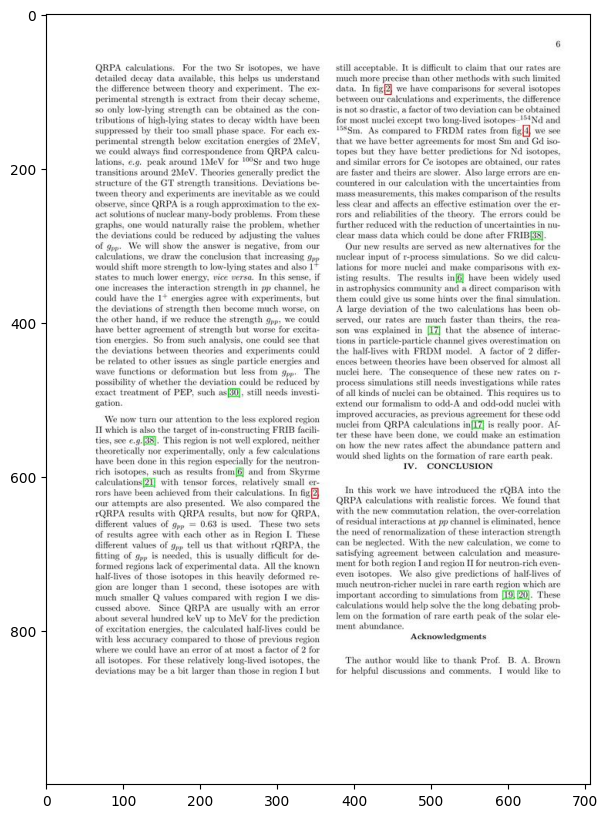

In [ ]:
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
import torch
from ultralytics import YOLO

images_path = Path('/content/drive/MyDrive/YOLO_v8/images/train')

#Mau test path
#images_path = Path('/content/drive/MyDrive/Computer Vision Dataset (Shared)/DocBankSubset/DocBank_subset_50')

jpg_files = list(images_path.glob('*.jpg'))

if not jpg_files:
    raise FileNotFoundError(f"No se encontraron archivos .jpg en {images_path}")

random_image_path = random.choice(jpg_files)

im = Image.open(random_image_path).convert('RGB')
transform = Compose([
    Resize((640, 640)),  # Ensure size is divisible by 32
    ToTensor()
])
show_image(im)

In [ ]:
from urllib.request import urlretrieve

fasterRCNN_labels = ['word']

a = urlretrieve("https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt", "labels.txt")

with open("labels.txt", "r") as f:
    for line in f.readlines():
        fasterRCNN_labels.append(line.replace("\n", ""))

### Preprocessing transformations

In [ ]:
from torchvision.transforms.functional import to_tensor



#We convert the im (image) to a pytorch tensor for the model
x = to_tensor(im).to(device)
targets = None

print("Before transform:", x.min(), x.max(), x.mean(), x.std())

transformed, _ = model.transform([x], targets)

print("After transform:", transformed.tensors[0].min(), transformed.tensors[0].max(),
      transformed.tensors[0].mean(), transformed.tensors[0].std())

Before transform: tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(0.9192, device='cuda:0') tensor(0.1753, device='cuda:0')
After transform: tensor(-2.0921, device='cuda:0') tensor(2.6400, device='cuda:0') tensor(2.0436, device='cuda:0') tensor(0.7291, device='cuda:0')


In [ ]:
transformed, _ = model.transform([x], targets)

### Feature Extraction

In [ ]:
feature_maps = model.backbone(transformed.tensors)
print({k: v.shape for k, v in feature_maps.items()})

{'0': torch.Size([1, 256, 288, 200]), '1': torch.Size([1, 256, 144, 100]), '2': torch.Size([1, 256, 72, 50]), '3': torch.Size([1, 256, 36, 25]), 'pool': torch.Size([1, 256, 18, 13])}


In [ ]:
feature_maps['0']

tensor([[[[ 0.3047, -0.2030,  0.4777,  ..., -0.0850, -0.6795, -0.2390],
          [-0.0497,  0.4245,  0.7866,  ...,  0.5071, -0.0737,  0.1347],
          [ 0.0294,  0.2373,  0.7253,  ...,  0.5327, -0.4799, -0.0434],
          ...,
          [ 1.2135,  0.5565,  0.7692,  ...,  0.8984, -0.2170, -0.3175],
          [ 0.5963,  0.1386,  0.3026,  ...,  0.2702, -0.4436, -0.5847],
          [ 0.3864,  0.7363,  0.6636,  ...,  0.8779,  0.3668, -0.2290]],

         [[ 0.2393, -0.0025, -0.0179,  ..., -0.8382, -0.7315, -0.0535],
          [ 1.4686,  0.7670,  0.7790,  ...,  0.4602,  0.2520,  1.2135],
          [ 1.1459,  0.1625,  0.1032,  ..., -0.0175,  0.4768,  1.2578],
          ...,
          [ 1.1540,  1.0100,  1.2860,  ...,  0.2564,  0.5365,  1.4888],
          [ 0.8847,  0.9789,  1.2965,  ...,  0.5503,  0.7210,  1.5315],
          [ 1.3174,  1.1086,  1.3005,  ...,  0.9998,  1.2783,  1.3012]],

         [[-0.5072,  0.1566, -0.1485,  ..., -0.5571, -1.1129,  0.0859],
          [ 0.8361,  1.2679,  

### Region proposal

In [ ]:
proposals, proposal_losses = model.rpn(transformed, feature_maps, targets)
proposals[0].shape


#We get:
#proposals: a list of tensors, one per image in the batch
#Each tensor contains N bounding boxes proposed by the RPN



torch.Size([2000, 4])

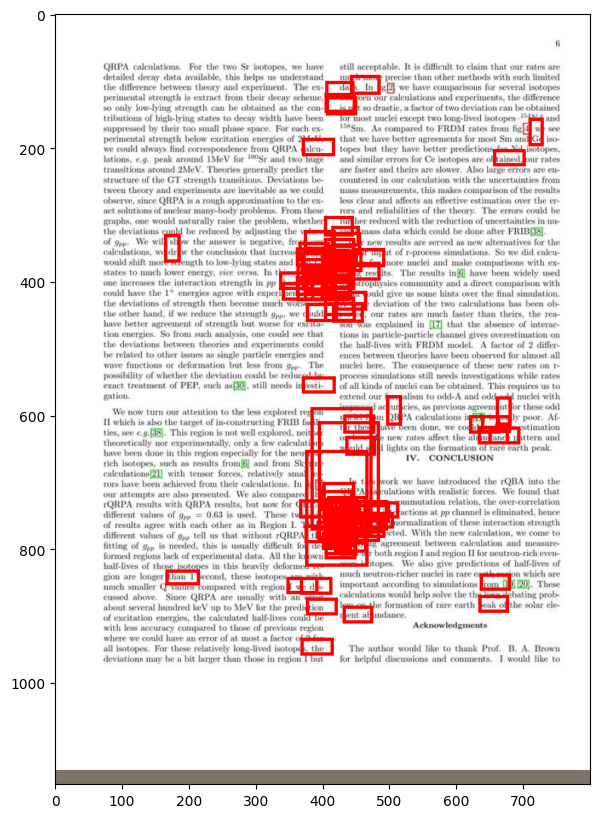

In [ ]:
'''
from torchvision.transforms.functional import to_pil_image

aux = transformed.tensors[0].cpu()
aux = aux*torch.tensor(model.image_std).reshape(3,1,1)+torch.tensor(model.image_mean).reshape(3,1,1)
transformed_im = to_pil_image(aux)
draw = ImageDraw.Draw(transformed_im)
for p in proposals[0][:2]:
    coords = p.cpu().detach().tolist()
    draw.rectangle(coords, width=5, outline="red")
show_image(transformed_im)

#Here we can:
#Debug whether the RPN is proposing useful object locations
#Understand how the model sees the scene before "classification"
#(Classification will not really be needed)
'''

from torchvision.transforms.functional import to_pil_image
from PIL import ImageDraw
import torch

# Define ImageNet normalization values manually
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

aux = transformed.tensors[0].cpu()
mean = torch.tensor(image_mean).reshape(3,1,1)
std = torch.tensor(image_std).reshape(3,1,1)

# De-normalize the image tensor
aux = aux * std + mean
aux = aux.clamp(0, 1)  # ensure values are in valid range

transformed_im = to_pil_image(aux)
draw = ImageDraw.Draw(transformed_im)

for p in proposals[0][:100]:
    coords = p.cpu().detach().tolist()
    draw.rectangle(coords, width=5, outline="red")

transformed_im.show()
show_image(transformed_im)


### ROI classifier and regressor

In [ ]:
import torch.nn.functional as F

In [ ]:
detections, detector_losses = model.roi_heads(feature_maps, proposals, transformed.image_sizes, targets)
detections = model.transform.postprocess(detections, transformed.image_sizes, [[im.height, im.width]])[0]

In [ ]:
print({k: v.shape for k, v in detections.items()})

{'boxes': torch.Size([200, 4]), 'labels': torch.Size([200]), 'scores': torch.Size([200])}


Number of yolo labels: 92
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
Label: 1
La

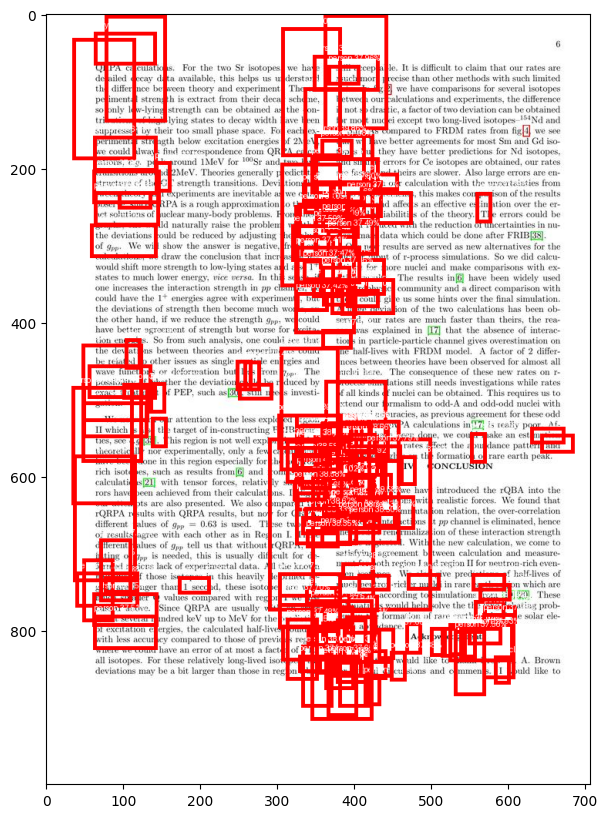

In [ ]:
import torchvision

iou_threshold = 0.4
scores_threshold = 0.1
keep_idx = torchvision.ops.nms(detections["boxes"], detections["scores"], iou_threshold)
boxes = [b for i, b in enumerate(detections["boxes"]) if i in keep_idx]
scores = [s for i, s in enumerate(detections["scores"]) if i in keep_idx]
labels = [l for i, l in enumerate(detections["labels"]) if i in keep_idx]

print(f"Number of yolo labels: {len(fasterRCNN_labels)}")
for label in labels:
    print("Label:", label.item())

draw = ImageDraw.Draw(im)
for box, score, label in zip(boxes, scores, labels):
    if score > scores_threshold:
        coords = box.cpu().tolist()
        draw.rectangle(coords, width=5,outline="red")
        text = f"{fasterRCNN_labels[label.item()]} {score*100:.2f}%"
        draw.text([coords[0], coords[1]-15], text)
show_image(im)


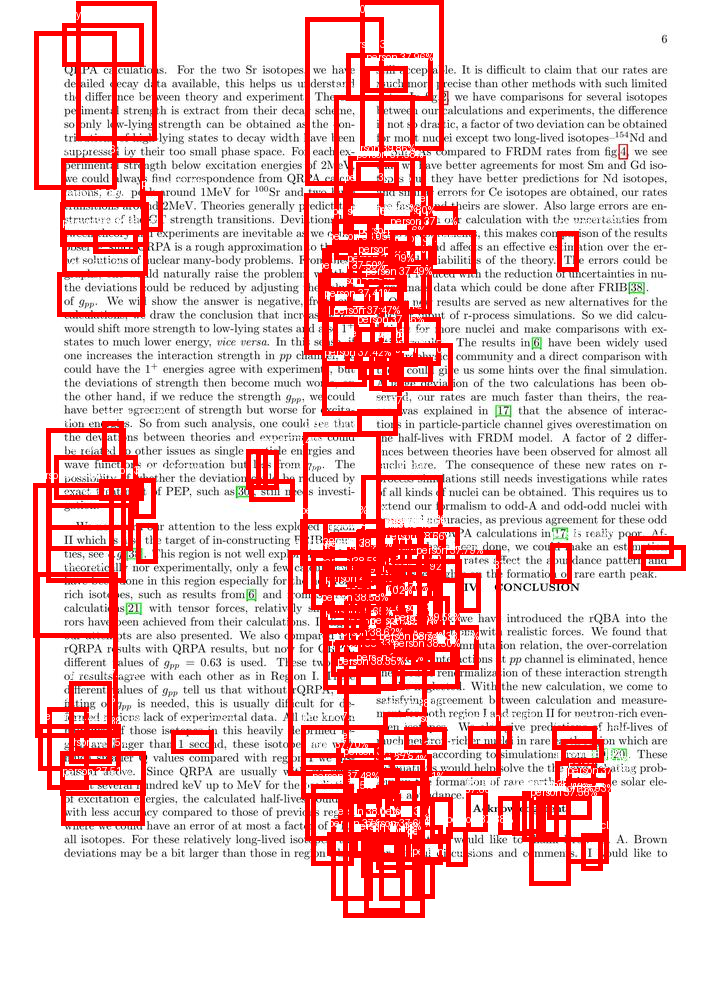

In [ ]:
im

### Transfer Learning

As we could see, the model itself is not able to detect the words over the images. We will feed the model with the data of our dataset and train it to be able to detect

In [ ]:
import torch.optim as optim

num_classes = 1

# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# move model to training mode and device
model = model.train().to(device)

## 4. Training the model

Now we will design the training loop

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
import os
from torch.utils.data import DataLoader

class DocBankDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, class_names, transforms=None):
        """
        images_dir: folder with images
        annotations_dir: folder with annotation txt files
        class_names: list of class names (e.g. ['abstract', 'author', ..., 'title'])
        transforms: torchvision transforms to apply on images and targets
        """
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms

        self.class_names = class_names
        self.class_to_idx = {c: i + 1 for i, c in enumerate(class_names)}  # class IDs start at 1
        # gather all image file names (without extension)
        self.image_files = sorted([
            f for f in os.listdir(images_dir)
            if f.lower().endswith(('.jpg', '.png', '.jpeg')) and
            os.path.exists(os.path.join(annotations_dir, os.path.splitext(f)[0] + ".txt"))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
      img_name = self.image_files[idx]
      img_path = os.path.join(self.images_dir, img_name)
      image = Image.open(img_path).convert("RGB")
      img_width, img_height = image.size

      # Apply resize + ToTensor transforms
      if self.transforms:
          image = self.transforms(image)

      annot_path = os.path.join(self.annotations_dir, os.path.splitext(img_name)[0] + ".txt")

      #print(f"Loading image: {img_path}, annotation: {annot_path}")
      if not os.path.exists(annot_path):
        print(f"Annotation file not found for image {img_name}")
        # Option 1: Skip this sample (not ideal for DataLoader)
        # Option 2: Raise an error with a clear message
        raise FileNotFoundError(f"Annotation file not found: {annot_path}")

      boxes = []
      labels = []

      with open(annot_path, 'r') as f:
          for line in f:
              parts = line.strip().split('\t')
              if len(parts) < 10:
                  continue

              try:
                  xmin = float(parts[1])
                  ymin = float(parts[2])
                  xmax = float(parts[3])
                  ymax = float(parts[4])
                  label_str = parts[-1]

                  if label_str not in self.class_to_idx:
                      continue

                  if xmax <= xmin or ymax <= ymin:
                      continue  # skip invalid boxes


                  #2.Scale to actual image dimensions
                  #annotations were created within a 1000x1000 grid
                  #and image sizes vary, so we account for that here

                  scale_x = img_width / 1000
                  scale_y = img_height / 1000

                  xmin *= scale_x
                  xmax *= scale_x
                  ymin *= scale_y
                  ymax *= scale_y

                  boxes.append([xmin, ymin, xmax, ymax])
                  labels.append(self.class_to_idx[label_str])
              except Exception as e:
                  print(f"Warning: Skipping bad line in {annot_path}: {line}")
                  continue

      if len(boxes) == 0:
          # Return a dummy target to avoid crashing — or you can skip this sample in training loop
          boxes = torch.zeros((0, 4), dtype=torch.float32)
          labels = torch.zeros((0,), dtype=torch.int64)

      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.as_tensor(labels, dtype=torch.int64)

      target = {
          "boxes": boxes,
          "labels": labels,
          "image_id": torch.tensor([idx]),
          "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
          "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64),
      }

      if self.transforms:
          image, target = self.transforms(image, target)
      else:
          image = ToTensor()(image)

      return image, target





In [ ]:
import wandb
#last lr was 0.005
#last batch size was 1
wandb.init(
    project="Computer_Vision",
    name="Resnet18_batch12_lr0.001-10K-trainSamples_10epochs",  # optional
    config={
        "epochs": 10,
        "batch_size": 12,
        "learning_rate": 0.001,
        "backbone":"resnet18_fpn",
        "dataset": "DocBank",
        "scheduler":"StepLR",
        "momentum": 0.95
    }
)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: toninoguerarecasens (adriabuil-upc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Clean the _ori over the names

In [ ]:
#Optional script
#transforms all files in a folder and strips the "_ori" in their names

root_dir = "/content/drive/MyDrive/YOLO_v8/images"

for dirpath, dirnames, filenames in os.walk(root_dir):
    for fname in filenames:
        if fname.endswith("_ori.jpg"):
            old_path = os.path.join(dirpath, fname)
            new_name = fname.replace("_ori", "")
            new_path = os.path.join(dirpath, new_name)
            os.rename(old_path, new_path)
            print(f"Renamed: {old_path} -> {new_path}")


Se han truncado las últimas 5000 líneas del flujo de salida.
Renamed: /content/drive/MyDrive/YOLO_v8/images/train/255.tar_1809.01155.gz_nonlinearNLSM1_8_ori.jpg -> /content/drive/MyDrive/YOLO_v8/images/train/255.tar_1809.01155.gz_nonlinearNLSM1_8.jpg
Renamed: /content/drive/MyDrive/YOLO_v8/images/train/54.tar_1802.10209.gz_axial-flow_6_ori.jpg -> /content/drive/MyDrive/YOLO_v8/images/train/54.tar_1802.10209.gz_axial-flow_6.jpg
Renamed: /content/drive/MyDrive/YOLO_v8/images/train/24.tar_1502.04237.gz_SpurCorr_Main_45_ori.jpg -> /content/drive/MyDrive/YOLO_v8/images/train/24.tar_1502.04237.gz_SpurCorr_Main_45.jpg
Renamed: /content/drive/MyDrive/YOLO_v8/images/train/65.tar_1604.03246.gz_TWC_v15_4_ori.jpg -> /content/drive/MyDrive/YOLO_v8/images/train/65.tar_1604.03246.gz_TWC_v15_4.jpg
Renamed: /content/drive/MyDrive/YOLO_v8/images/train/184.tar_1609.08580.gz_DarkJan5_4_ori.jpg -> /content/drive/MyDrive/YOLO_v8/images/train/184.tar_1609.08580.gz_DarkJan5_4.jpg
Renamed: /content/drive/MyDri

### Training code

In [ ]:
"""Train the model using the DocBankDataset with FasterRCNN"""
import os
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

def print_gpu_report():
    print(f"[GPU MEM] Allocated: {torch.cuda.memory_allocated() / 1e6:.2f} MB")
    print(f"[GPU MEM] Cached   : {torch.cuda.memory_reserved() / 1e6:.2f} MB")

# Define collate_fn to handle batches of varying-size targets
def collate_fn(batch):
    return tuple(zip(*batch))

def train_model(epochs):
    """Train the model using the DocBankDataset with FasterRCNN"""
    #Base path
    dataset_dir = Path('/content/drive/MyDrive/YOLO_v8')

    # Device setup
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Using device: {device}")

    # Class names (must match your dataset.yaml and annotations)
    class_names = ['paragraph']
    #class_names = ['paragraph', 'caption']

    # Instantiate your DocBankDataset (make sure annotations path is correct)
    train_dataset = DocBankDataset(
        images_dir= dataset_dir / "images/train",
        annotations_dir= dataset_dir / "transformed_labels/train",
        class_names=class_names,
        transforms=None
    )

    # Validation dataset
    val_dataset = DocBankDataset(
        images_dir= dataset_dir / "images/val",
        annotations_dir= dataset_dir / "transformed_labels/val",
        class_names=class_names,
        transforms=None
    )


    # DataLoaders for batching
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn
    )

    model.to(device)

    # Optimizer #previous momentum was 0.9
    optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9, weight_decay=0.0005)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR every 5 epochs by a factor of 0.1

    num_epochs = epochs
    wandb.watch(model, log="all", log_freq=10)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print_gpu_report()

        model.train()
        train_loss = 0.0


        for i, (images, targets) in enumerate(train_loader):
            for t in targets:
                print(f"TARGET VALUE: {t}")
                if len(t["labels"]) <= 0:
                    print("labels are empty")
                    print(t["labels"])

                if torch.isnan(t["boxes"]).any() or torch.isinf(t["boxes"]).any():
                    print("Found NaN or Inf in boxes!")
                if torch.isnan(t["labels"]).any() or torch.isinf(t["labels"]).any():
                    print("Found NaN or Inf in labels!")

            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Skip any batch with empty targets
            if any(len(t["boxes"]) == 0 for t in targets):
                print(f"Skipping empty target at step {i}")
                continue

            # Forward pass
            loss_dict = model(images, targets)  # no need for _


            # Sum losses
            losses = sum(loss for loss in loss_dict.values())
            train_loss += losses.item()

            # Backpropagation
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if i % 60 == 0:
                loss_str = ", ".join([f"{k}: {v.item():.3f}" for k, v in loss_dict.items()])
                print(f"Step {i}/{len(train_loader)}: {loss_str}")

        # Calculate average training loss for the epoch
        train_loss /= len(train_loader)


        #model.eval()
        model.train()  # Needed to compute losses
        val_loss = 0.0
        with torch.no_grad():
            for i, (images, targets) in enumerate(val_loader):
                images = list(img.to(device) for img in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                if any(len(t["boxes"]) == 0 for t in targets):
                    continue

                loss_dict = model(images, targets)
                losses = sum(loss.item() for loss in loss_dict.values())
                val_loss += losses

                if i % 80 == 0:
                    loss_str = ", ".join([f"{k}: {v.item():.3f}" for k, v in loss_dict.items()])
                    print(f"Validation Step {i}/{len(val_loader)}: {loss_str}")

        val_loss /= len(val_loader)
        model.eval()  # Reset after validation

        scheduler.step()  # Step the scheduler

        # Validation
        # Optional: compare predictions to targets, save them, or compute IoU/mAP


        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "lr": optimizer.param_groups[0]['lr']
        })

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        print_gpu_report()
        #print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}")

    print("Training complete")
    return model


In [ ]:
# Paso 2: Entrenar el modelo
model = train_model(10)

Using device: cuda
Epoch 1/10
[GPU MEM] Allocated: 594.04 MB
[GPU MEM] Cached   : 824.18 MB
TARGET VALUE: {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([4564]), 'area': tensor([]), 'iscrowd': tensor([], dtype=torch.int64)}
labels are empty
tensor([], dtype=torch.int64)
TARGET VALUE: {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([2367]), 'area': tensor([]), 'iscrowd': tensor([], dtype=torch.int64)}
labels are empty
tensor([], dtype=torch.int64)
TARGET VALUE: {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([2117]), 'area': tensor([]), 'iscrowd': tensor([], dtype=torch.int64)}
labels are empty
tensor([], dtype=torch.int64)
TARGET VALUE: {'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'image_id': tensor([349]), 'area': tensor([]), 'iscrowd': tensor([], dtype=torch.int64)}
labels are empty
tensor([], dtype=torch.int64)
S

KeyboardInterrupt: 

### Save model

In [ ]:
#Guardar el modelo entrenado
torch.save(model.state_dict(), "model.pth")

#Subir el modelo como artifact
artifact = wandb.Artifact(
    name=f"Resnet18-10k-v{wandb.run.id}",
    type="model",
    description="Modelo de testing entrenado con 10 epochs y dataset de 10k imagenes",
    metadata={"epochs": 10}
)
artifact.add_file("model.pth")
wandb.log_artifact(artifact)


<Artifact fasterrcnn-resnet18-model>

In [ ]:
wandb.finish()

In [ ]:
model.eval()
with torch.no_grad():
    detections, _ = model(images)

print(len(detections[0]['boxes']))  # should now be <= 200

In [ ]:
import wandb
import torch
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# 1. Init wandb
wandb.init(project="Computer_Vision", job_type="inference")

# 2. Load artifact
artifact = wandb.use_artifact('adriabuil-upc/Computer_Vision/Resnet18-10k-vebxxwlq0:latest', type='model')
artifact_dir = artifact.download()

# 3. Declare the same model architecture
backbone = resnet_fpn_backbone('resnet18', pretrained=True)
model2 = FasterRCNN(backbone, num_classes=13)  # 2 classes + background
model2.to(device)

# 4. Load state dict
checkpoint_path = f"{artifact_dir}/model.pth"
state_dict = torch.load(checkpoint_path, map_location=device)
model2.load_state_dict(state_dict)

## 5. Evaluación del modelo

Después del entrenamiento, podemos evaluar el modelo en el conjunto de prueba:

Prediction keys: dict_keys(['boxes', 'labels', 'scores'])
Num boxes: 100
Scores: tensor([0.6920, 0.6792, 0.6677, 0.6604, 0.6582, 0.6448, 0.6415, 0.6413, 0.6406, 0.6380, 0.6312, 0.6285, 0.6283, 0.6258, 0.6247, 0.6233, 0.6227, 0.6225, 0.6215, 0.6201, 0.6195, 0.6186, 0.6181, 0.6181, 0.6170, 0.6165, 0.6163, 0.6159, 0.6130, 0.6124, 0.6107, 0.6097, 0.6087, 0.6072, 0.6041, 0.6033, 0.6021, 0.5983, 0.5978,
        0.5974, 0.5958, 0.5948, 0.5931, 0.5909, 0.5890, 0.5885, 0.5868, 0.5846, 0.5828, 0.5804, 0.5797, 0.5796, 0.5791, 0.5759, 0.5756, 0.5741, 0.5732, 0.5727, 0.5723, 0.5717, 0.5713, 0.5662, 0.5658, 0.5653, 0.5646, 0.5642, 0.5632, 0.5629, 0.5615, 0.5612, 0.5612, 0.5606, 0.5604, 0.5600, 0.5594, 0.5593, 0.5592, 0.5580,
        0.5570, 0.5547, 0.5544, 0.5523, 0.5510, 0.5495, 0.5488, 0.5484, 0.5483, 0.5478, 0.5467, 0.5456, 0.5455, 0.5438, 0.5424, 0.5420, 0.5418, 0.5410, 0.5401, 0.5395, 0.5383, 0.5363], device='cuda:0')


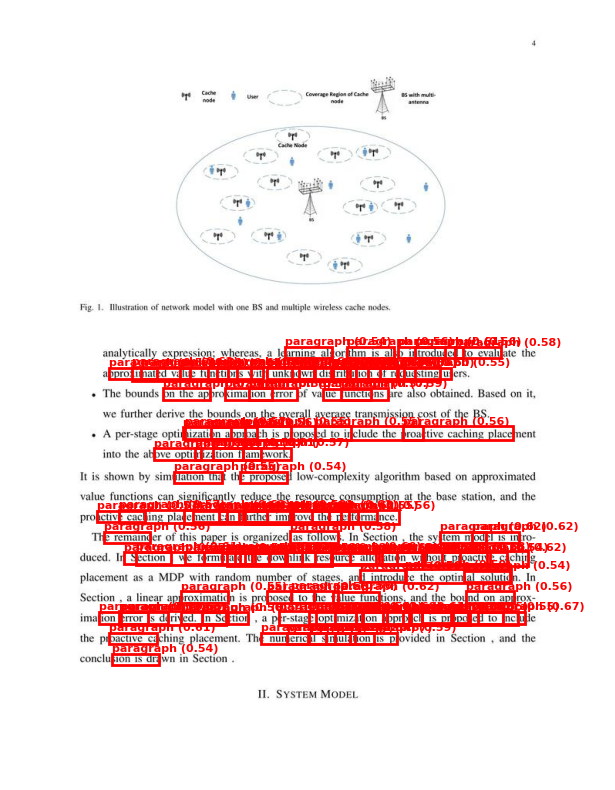

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path

# Set up base directory
dataset_dir = Path('/content/drive/MyDrive/YOLO_v8')

# Define your class names
class_names = ['word']

# Create the test dataset
test_dataset = DocBankDataset(
    images_dir=dataset_dir / "images/test",
    annotations_dir=dataset_dir / "transformed_labels/test",
    class_names=class_names,
    transforms=None
)


# Pick a test sample
idx = num_samples = len(test_dataset)

idx = random.randint(0, num_samples - 1)
image, target = test_dataset[idx]
image = image.to(device)

# Run inference

model.eval()
with torch.no_grad():
    prediction = model([image])[0][0]
    print("Prediction keys:", prediction.keys())
    print("Num boxes:", len(prediction['boxes']))
    print("Scores:", prediction['scores'])


    #print(prediction)

# Move image to CPU for visualization
image_np = image.cpu().permute(1, 2, 0).numpy()

# Visualize predicted boxes
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
ax = plt.gca()

# Draw predictions with confidence > 0.5
total = 0
for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
    if score >= 0.75:
        total += 1
        xmin, ymin, xmax, ymax = box.cpu()
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        label_name = class_names[label - 1]  # adjust for background
        ax.text(xmin, ymin - 2, f"{label_name} ({score:.2f})", color='red', fontsize=8, weight='bold')


print(f"Total: {total}")
plt.axis("off")
plt.show()



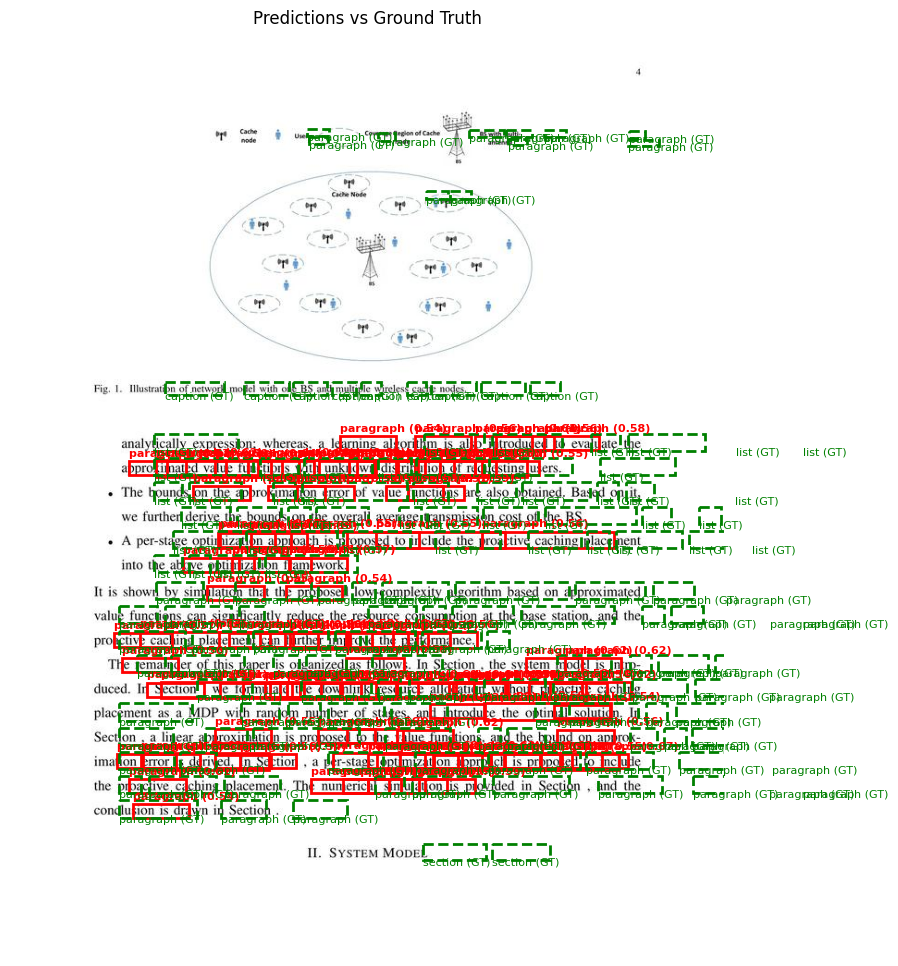

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image

# Dataset location and classes
dataset_dir = Path('/content/drive/MyDrive/YOLO_v8')
class_names = ['word']


# Pick a test sample
image, target = test_dataset[idx]

# Convert to tensor if needed
if isinstance(image, Image.Image):
    image = ToTensor()(image)

image = image.to(device)

# Run inference
model.eval()
with torch.no_grad():
    prediction = model([image])[0]
    #prediction = prediction[0]

# Move image back to CPU for plotting
image_np = image.cpu().permute(1, 2, 0).numpy()

# Visualization
plt.figure(figsize=(12, 12))
plt.imshow(image_np)
ax = plt.gca()

#predicted boxes (in red)
for box, label, score in zip(prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']):
    if score > 0.4:
        xmin, ymin, xmax, ymax = box.cpu().numpy()
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        label_name = class_names[label - 1]
        ax.text(xmin, ymin - 5, f"{label_name} ({score:.2f})", color='red', fontsize=8, weight='bold')


#round truth boxes (in green)
for box, label in zip(target['boxes'], target['labels']):
    xmin, ymin, xmax, ymax = box.cpu().numpy()
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2, edgecolor='green', facecolor='none', linestyle='--')
    ax.add_patch(rect)
    label_name = class_names[label - 1]
    ax.text(xmin, ymax + 5, f"{label_name} (GT)", color='green', fontsize=8)


plt.axis("off")
plt.title("Predictions vs Ground Truth")
plt.show()


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

print("Running final evaluation on test dataset...")

all_gt_labels = []
all_pred_labels = []

model.eval()
with torch.no_grad():
    for idx in range(len(test_dataset)):
        image, target = test_dataset[idx]
        image_gpu = image.to(device).unsqueeze(0)

        output_raw = model(image_gpu)[0][0] if isinstance(model(image_gpu)[0], list) else model(image_gpu)[0]
        pred_labels = output_raw['labels'].cpu().numpy().tolist()
        gt_labels = target['labels'].cpu().numpy().tolist()

        # Extend global lists
        all_gt_labels.extend(gt_labels)
        all_pred_labels.extend(pred_labels)

# Compute confusion matrix
cm = confusion_matrix(all_gt_labels, all_pred_labels, labels=list(range(1, len(class_names)+1)))

# ------------------------------------------------------
# 📊 Show matrix as heatmap in Google Colab
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix on Test Set")
plt.show()

# ------------------------------------------------------
# 📈 Log interactive matrix to W&B
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
    preds=all_pred_labels,
    y_true=all_gt_labels,
    class_names=class_names
)})


## 6.Image crops -> OCR model

In [ ]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import ImageOps

def extract_crops(image_tensor, prediction, score_threshold=0.55):
    """
    image_tensor: torch.Tensor, shape (3, H, W) — before transforms
    prediction: model output dictionary (boxes, scores, etc.)
    Returns: List of cropped PIL images
    """
    boxes = prediction["boxes"]
    scores = prediction["scores"]

    crops = []

    # Convert original tensor image to PIL (for easy cropping)
    image_pil = to_pil_image(image_tensor.cpu())

    for box, score in zip(boxes, scores):
        if score < score_threshold:
            continue

        x1, y1, x2, y2 = map(int, box.tolist())
        crop = image_pil.crop((x1, y1, x2, y2))
        crops.append(crop)

    return crops




def show_crops(crops):
    """
    Display each crop vertically with clear separation and border.
    """
    if not crops:
        print("No crops to display.")
        return

    padded_crops = [ImageOps.expand(crop, border=5, fill='black') for crop in crops]

    # Stack all images vertically
    total_height = sum(crop.height for crop in padded_crops) + (10 * len(crops))
    max_width = max(crop.width for crop in padded_crops)

    combined_image = Image.new("RGB", (max_width, total_height), "white")

    y_offset = 0
    for crop in padded_crops:
        combined_image.paste(crop, (0, y_offset))
        y_offset += crop.height + 10

    plt.figure(figsize=(8, total_height // 100))
    plt.imshow(combined_image)
    plt.axis('off')
    plt.show()

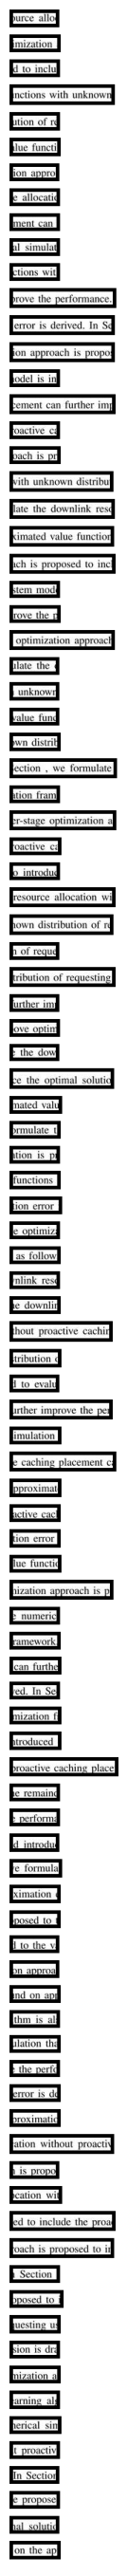

In [ ]:
# 1. Load the image and clone the original
image, target = test_dataset[idx]

original_image_tensor = image.clone()  # already a torch.Tensor

# 2. Inference
image = image.to(device)
model.eval()
with torch.no_grad():
    detections, losses = model([image])   # <-- unpack the tuple
    prediction = detections[0]            # <-- get the first image's predictions (a dict)


#Extract and visualize crops
crops = extract_crops(original_image_tensor, prediction, score_threshold=0.4)
show_crops(crops)

Añadir wordcount total sobre el documento para poder evaluar la detección de las palabras.



## Notas importantes

